# Spaceship Titanic

### 🚣‍♂️목적 
우주선 타이타닉 어떤 승객이 다른 차원으로 이동할지 예측

</br>

### 🧩특징 
우주 미스터리를 풀기 위해 여러분의 데이터 과학 기술이 필요한 2912년에 오신 것을 환영합니다.  
4광년 떨어진 곳에서 전송이 왔는데 상황이 좋지 않아요

우주선 타이타닉은 한 달 전에 발사된 성간 여객선입니다.  
거의 13,000명의 승객을 태운 이 배는 태양계에서 온 이민자들을  
근처의 별 주위를 도는 세 개의 새로이 거주할 수 있는 외계 행성으로 실어 나르는 처녀 항해를 시작했습니다.

첫 번째 목적지인 55호 암크리 E로 알파 센타우리를 도는 동안,  
조심성이 없는 우주선 타이타닉은 먼지 구름 속에 숨겨진 시공간 변칙과 충돌했습니다.  
안타깝게도, 그것은 1000년 전의 이름과 비슷한 운명을 만났습니다. 비록 그 배는 온전하게 유지되었지만,  
거의 절반의 승객들은 다른 차원으로 옮겨졌습니다!  

승무원을 구조하고 잃어버린 승객을 되찾는 것을 돕기 위해,  
여러분은 우주선의 손상된 컴퓨터 시스템에서 복구된 기록을 사용하여  
어떤 승객들이 이상 현상에 의해 이송되었는지 예측해야 합니다.

그들을 구하고 역사를 바꾸도록 도와주세요!

</br>

### 📔코드북
`train.csv` - 승객의 약 3분의 2(~8700)에 대한 개인 기록
- `PassengerId` - 각 승객의 고유 ID. 각 Id는 ggg_pp 형식을 취함  
    - gggg: 승객과 함께 여행하는 그룹  
    - pp: 그룹 내 승객의 번호  
    - 그룹의 사람들은 가족 구성원 또는 아닐 수 있음
- `HomePlanet` - 승객이 출발한 행성, 일반적으로 영구 거주지의 행성 
- `CryoSleep` - 승객이 항해 중 가사상태로 선출되었는지 여부
    - 극저온 수면 중인 승객들은 객실에 갇혀 있음 
- `Cabin` - 객실 번호(deck/num/side)
    - side: Port의 경우 P, Starboard의 경우 S
- `Destination` - 승객이 내릴 행선지
- `Age` - 승객의 연령
- `VIP` - 승객이 항해 중 특별 VIP 서비스 비용을 지불했는지 여부
- `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - 승객들이 우주선 타이타닉의 많은 고급 편의시설 각각에 청구한 금액
- `Name` - 승객의 이름
- `Transported` - 승객이 다른 차원으로 운송되었는지 여부, target값

`test.csv` - 남은 승객의 1/3(약 4300명)에 대한 개인 기록
    - 승객에 대한 Transported 값을 예측 


[출처] <a href="https://www.kaggle.com/competitions/spaceship-titanic/overview/description">Spaceship Titanic</a>

# Step 1. Imports

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots


from sklearn.impute import SimpleImputer  # 결측치 대체
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split


from lightgbm import LGBMClassifier

import time
import warnings
warnings.filterwarnings('ignore')

# Step 2. Data Loading and Preperation

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

RANDOM_STATE = 12
FOLDS = 5
STRATEGE = 'median'

## Exploring Train Data
* 14개의 열과 8693개의 행이다.
* 2324개의 결측값을 포함한 119378개의 관측값이 있다.
* 12개의 열은 모두 결측값이 있고 CryoSleep이 결측값은 217개로 가장 많다.
* Transported는 train dataset에만 있는 target이다.

### Quick View of Train Data 
Below are the first 5 rows of train dataset:

In [5]:
display(train.head())
print(f"\33[92mtrain data의 행 개수: {train.shape[0]}")
print(f"train data의 열 개수: {train.shape[1]}")
print(f"train data의 관측값: {train.count().sum()}")
print(f"train data의 결측값: {train.isna().sum().sum()}")

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


train data의 행 개수: 8693
train data의 열 개수: 14
train data의 관측값: 119378
train data의 결측값: 2324


Column Wise missing values : 

In [6]:
print(f'\33[92m')
print(train.isna().sum().sort_values(ascending = False))


CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64


Basic statistics of training data:

In [7]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,28.827930,14.489021,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0


## Exploring Test Data
### Quick View of Test Data 
Below are the first 5 rows of test dataset:

In [8]:
display(test.head())
print(f"\33[92mtest data의 행 개수: {test.shape[0]}")
print(f"test data의 열 개수: {test.shape[1]}")
print(f"test data의 관측값: {test.count().sum()}")
print(f"test data의 결측값: {test.isna().sum().sum()}")

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


test data의 행 개수: 4277
test data의 열 개수: 13
test data의 관측값: 54484
test data의 결측값: 1117


Column Wise missing values : 

In [9]:
print(f'\33[92m')
print(test.isna().sum().sort_values(ascending = False))


FoodCourt       106
Spa             101
Cabin           100
ShoppingMall     98
Name             94
CryoSleep        93
VIP              93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
PassengerId       0
dtype: int64


Basic statistics of training data:

In [10]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,4186.0,28.658146,14.179072,0.0,19.0,26.0,37.0,79.0
RoomService,4195.0,219.266269,607.011289,0.0,0.0,0.0,53.0,11567.0
FoodCourt,4171.0,439.484296,1527.663045,0.0,0.0,0.0,78.0,25273.0
ShoppingMall,4179.0,177.295525,560.821123,0.0,0.0,0.0,33.0,8292.0
Spa,4176.0,303.052443,1117.186015,0.0,0.0,0.0,50.0,19844.0
VRDeck,4197.0,310.710031,1246.994742,0.0,0.0,0.0,36.0,22272.0


### Quick View of Submission Data 

In [11]:
submission.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


# Step 3. EDA

### Overview of Data

In [12]:
train = train.drop(["PassengerId"], axis=1)
test = test.drop(["PassengerId"], axis=1)
TARGET = 'Transported'
FEATURES = [col for col in train.columns if col != TARGET]
RANDOM_STATE = 12

In [13]:
train.iloc[:, :-1].describe().T.sort_values(by='std', ascending=False)\
                    .style.background_gradient(cmap='GnBu')\
                    .bar(subset=["max"], color='#BB0000')\
                    .bar(subset=["mean",], color='green')

,count,mean,std,min,25%,50%,75%,max
FoodCourt,8510.000000,458.077203,1611.489240,0.000000,0.000000,0.000000,76.000000,29813.000000
VRDeck,8505.000000,304.854791,1145.717189,0.000000,0.000000,0.000000,46.000000,24133.000000
Spa,8510.000000,311.138778,1136.705535,0.000000,0.000000,0.000000,59.000000,22408.000000
RoomService,8512.000000,224.687617,666.717663,0.000000,0.000000,0.000000,47.000000,14327.000000
ShoppingMall,8485.000000,173.729169,604.696458,0.000000,0.000000,0.000000,27.000000,23492.000000
Age,8514.000000,28.827930,14.489021,0.000000,19.000000,27.000000,38.000000,79.000000


### Null Value Distribution

### 📌  Observations in Null Value Distribution :  
* 행의 결측값의 최대값은 3이며 가장 낮은 값은 결측값이 아닙니다.  
* 흥미롭게도, 결측값 분포(행 기준)는 train와 test dataset 간에 상당히 동일합니다.  
* 결측값이 없는 관측치(행 기준)는 약 76%입니다.  
* 나머지 관측치의 24%(행 기준)는 결측값이 1-3개입니다  

### Column wise Null Value Distribution

In [14]:
train_null = pd.DataFrame(train.isna().sum()).sort_values(by=0 ,ascending=False)[:-1]
display(train_null)

test_null = pd.DataFrame(test.isna().sum()).sort_values(by=0 ,ascending=False)
display(test_null)

,0
CryoSleep,217
ShoppingMall,208
VIP,203
HomePlanet,201
Name,200
Cabin,199
VRDeck,188
FoodCourt,183
Spa,183
Destination,182


,0
FoodCourt,106
Spa,101
Cabin,100
ShoppingMall,98
Name,94
CryoSleep,93
VIP,93
Destination,92
Age,91
HomePlanet,87


In [15]:
fig = make_subplots(rows=1, 
                    cols=2,
                    column_titles = ["Train Data", "Test Data"] ,
                    x_title="Missing Values")

fig.add_trace(go.Bar(x=train_null[0],
                     y=train_null.index,
                     orientation="h",
                     marker=dict(color=[n for n in range(12)], 
                                 line_color='rgb(0,0,0)' , 
                                 line_width = 2,
                                 coloraxis="coloraxis")),
              1, 1)
fig.add_trace(go.Bar(x=test_null[0], 
                     y=test_null.index,
                     orientation="h",
                     marker=dict(color=[n for n in range(12)], 
                                 line_color='rgb(0,0,0)', 
                                 line_width = 2,
                                 coloraxis="coloraxis")),
              1, 2)

fig.update_layout(showlegend=False, title_text="Column wise Null Value Distribution", title_x=0.5)

In [16]:
missing_train_row = train.isna().sum(axis=1)
missing_train_row = pd.DataFrame(missing_train_row.value_counts()/train.shape[0]).reset_index()
missing_test_row = test.isna().sum(axis=1)
missing_test_row = pd.DataFrame(missing_test_row.value_counts()/test.shape[0]).reset_index()

In [17]:
missing_train_row.columns = ['no', 'count']
missing_test_row.columns = ['no', 'count']
missing_train_row["count"] = missing_train_row["count"]*100
missing_test_row["count"] = missing_test_row["count"]*100


fig = make_subplots(rows=1, 
                    cols=2,
                    column_titles = ["Train Data", "Test Data"] ,
                    x_title="Missing Values",)

fig.add_trace(go.Bar(x=missing_train_row["no"], 
                     y=missing_train_row["count"]  ,
                    marker=dict(color=[n for n in range(4)], 
                                line_color='rgb(0,0,0)' ,
                                line_width = 3
                                ,coloraxis="coloraxis")),
              1, 1)
fig.add_trace(go.Bar(x= missing_test_row["no"], 
                     y=missing_test_row["count"],
                    marker=dict(color=[n for n in range(4)], 
                                line_color='rgb(0,0,0)',
                                line_width = 3 ,
                                coloraxis="coloraxis")),
              1, 2)
fig.update_layout(showlegend=False, title_text="Row wise Null Value Distribution", title_x=0.5)

### 📌  Observations in Continuos and Categorical Data Distribution :  
* 12개 피처 중 6개의 피처는 연속형, 2개의 피처는 텍스트 데이터, 4개의 피처는 범주형입니다.
* HomePlanet과 Destination에는 세 가지 고유한 값이 있습니다.
* CryoSleep과 VIP는 bool type 입니다.

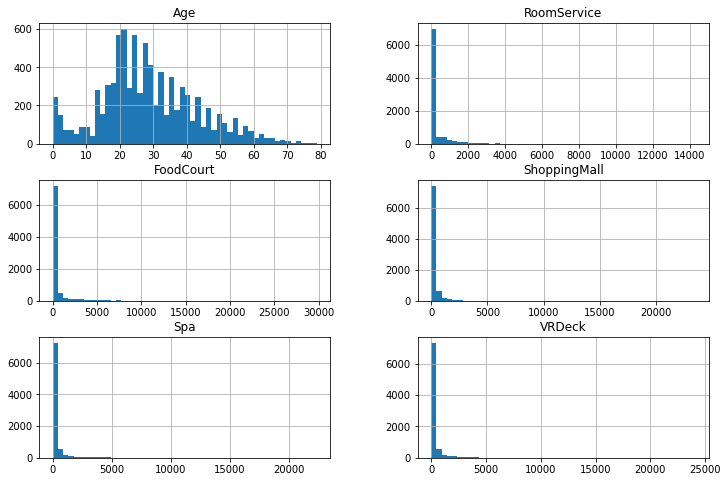

In [18]:
_ = train.hist(figsize=(12, 8), bins=50)

In [19]:
df = pd.concat([train[FEATURES], test[FEATURES]], axis=0)
text_features = ["Cabin", "Name"]

# ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
cat_features = [col for col in FEATURES if df[col].nunique() < 25 and col not in text_features]

# ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
cont_features = [col for col in FEATURES if df[col].nunique() >= 25 and col not in text_features]

del df


In [20]:
print(f'\33[92mTotal number of features: {len(FEATURES)}')
print(f'\33[92mNumber of categorical features: {len(cat_features)}')
print(f'\33[92mNumber of continuos features: {len(cont_features)}')
print(f'\33[92mNumber of text features: {len(text_features)}')

Total number of features: 12
Number of categorical features: 4
Number of continuos features: 6
Number of text features: 2


In [21]:
labels=['Categorical', 'Continuos', "Text"]
values= [len(cat_features), len(cont_features), len(text_features)]
colors = ['#DE3163', '#58D68D']

fig = go.Figure(data=[go.Pie(
    labels=labels, 
    values=values, pull=[0.1, 0, 0 ],
    marker=dict(colors=colors, 
                line=dict(color='#000000', 
                          width=2))
)])
fig.show()

### Distribution of Age

In [22]:
train_age = train.copy()
test_age = test.copy()
train_age["type"] = "Train"
test_age["type"] = "Test"
ageDf = pd.concat([train_age, test_age])

fig = px.histogram(data_frame=ageDf, 
                   x="Age",
                   color= "type",
                   color_discrete_sequence=['#58D68D','#DE3163'],
                   marginal="box",
                   nbins= 100,
                   template="plotly_white"
                )
fig.update_layout(title = "Distribution of Age" , title_x = 0.5)
fig.show()

### Feature Distribution of Continous Features

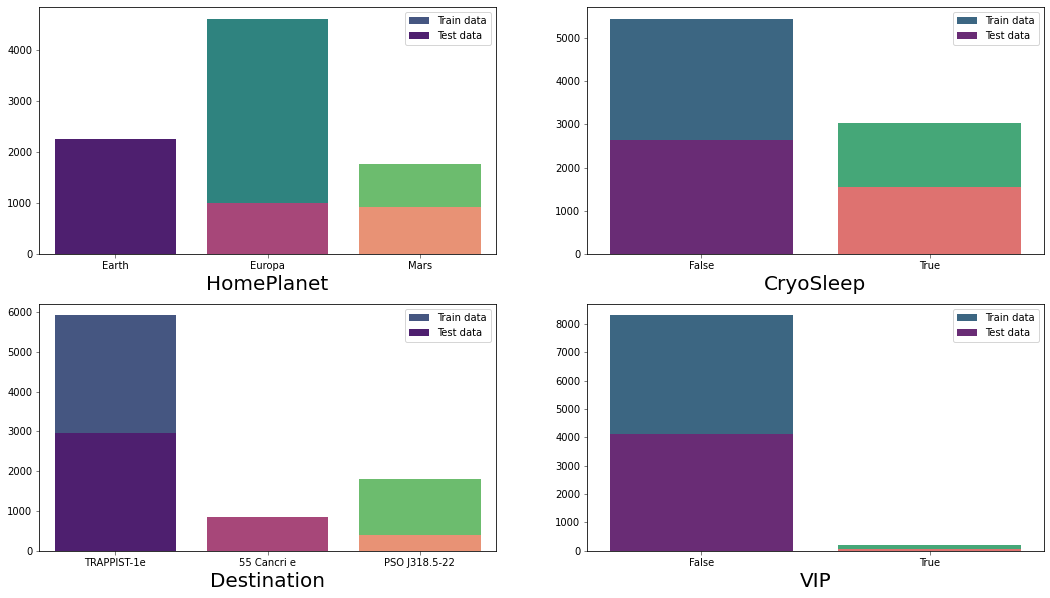

In [23]:
if len(cat_features) == 0 :
    print("No Categorical features")
else:
    ncols = 2
    nrows = 2

    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 10))
    for r in range(nrows):
        for c in range(ncols):
            col = cat_features[r*ncols+c]
            sns.countplot(train[col], ax=axes[r,c] ,palette="viridis", label='Train data')
            sns.countplot(test[col], ax=axes[r,c] ,palette="magma", label='Test data')
            axes[r,c].legend()
            axes[r,c].set_ylabel('')
            axes[r,c].set_xlabel(col, fontsize=20)
            axes[r,c].tick_params(labelsize=10, width=0.5)
            axes[r,c].xaxis.offsetText.set_fontsize(4)
            axes[r,c].yaxis.offsetText.set_fontsize(4)
    plt.show()

### Target Distribution

📌  Observations in Target Distribution :
* Target의 값은 0과 1이다.
* 0과 1은 거의 동등한 분포다.

In [24]:
target_df = pd.DataFrame(train[TARGET].value_counts()).reset_index()
target_df.columns = [TARGET, 'count']

print("\33[94mPercentage of Transported = 0: {:.2f} %".format(target_df["count"][0]*100 / train.shape[0]))
print("\33[94mPercentage of Transported = 1: {:.2f} %".format(target_df["count"][1]*100 / train.shape[0]))

Percentage of Transported = 0: 50.36 %
Percentage of Transported = 1: 49.64 %


### Correlation Metrix

In [25]:
fig = px.imshow(train.corr(), text_auto=True, aspect="auto", color_continuous_scale = "brwnyl")
fig.show()

# Step 4. Data Pre-Processing

### Imputing Missing Values

[참고] <a href="https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html"> sklearn SimpleImputer </a>

In [26]:
cont_features

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [27]:
imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService"]
imputer = SimpleImputer(strategy='median')
imputer.fit(train[imputer_cols])

SimpleImputer(strategy='median')

In [28]:
train[imputer_cols] = imputer.transform(train[imputer_cols])
test[imputer_cols] = imputer.transform(test[imputer_cols])

<a href="https://fictspedia.fandom.com/wiki/Planet_Z">🪐planet Z... </a>

In [29]:
train["HomePlanet"] = train["HomePlanet"].fillna('Z')
test["HomePlanet"] = test["HomePlanet"].fillna('Z')

### Encoding Categorical Features

In [30]:
text_features

['Cabin', 'Name']

In [31]:
cat_features

['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

In [32]:
# label_cols = ["HomePlanet", "CryoSleep", "Cabin", "Destination" ,"VIP"]
# def labelEncoder(data, columns):
#     for col in columns:
#         labels = []
#         l_encoder = LabelEncoder()
#         items = data[col]
#         l_encoder.fit(items)
#         labels = l_encoder.transform(items)
#         data[col] = labels
#         le_name_mapping = dict(zip(l_encoder.classes_, l_encoder.transform(l_encoder.classes_)))
        
#         print(le_name_mapping)

In [33]:
# labelEncoder(train, label_cols)

In [34]:
label_cols = ["HomePlanet", "CryoSleep","Cabin", "Destination" ,"VIP"]
def label_encoder(train, test, columns):
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = LabelEncoder().fit_transform(train[col])
        test[col] =  LabelEncoder().fit_transform(test[col])
    return train, test

train, test = label_encoder(train, test ,label_cols)

In [35]:
train.drop(["Name" ,"Cabin"] , axis = 1 ,inplace = True)
test.drop(["Name" ,"Cabin"] , axis = 1 ,inplace = True)
X = train.drop(TARGET , axis =1 )
y = train[TARGET]
X_train , X_test , y_train , y_test = train_test_split(X , 
                                                       y, 
                                                       random_state = 12 ,
                                                       test_size =0.33)

# Step 5. Modeling

# Step 6. Submission